In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [141]:
%matplotlib inline

import math
import numpy as np
import imageio
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
import pytesseract
import cv2
import re
from PIL import Image, ImageFont, ImageDraw

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

# tmp = imageio.imread('./Images/test.png')
# plt.imshow(tmp[:,:,0])
# plt.show()
# print(pytesseract.image_to_string(tmp))

# -----------------------------------------------

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
from art.estimators.classification import BlackBoxClassifier
from art.defences.preprocessor import JpegCompression
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [349]:
image_target = imageio.imread('./Images/dissent.png')
image_init = imageio.imread('./Images/assent.png')

# # add a channel dimension for jpeg compression
# image_target = np.expand_dims(image_target, axis=-1)
# image_init = np.expand_dims(image_init, axis=-1)

# Converting 2D to 3D images
image_target = cv2.cvtColor(image_target, cv2.COLOR_GRAY2RGB)
image_init = cv2.cvtColor(image_init, cv2.COLOR_GRAY2RGB)

def predict(x):
    i = 0
    out_label = []
    for x_i in x:
        x_i = x_i.astype(np.uint8)
        out_string = pytesseract.image_to_string(x_i).strip()
        if out_string == 'dissent':
            out_label.append(0)
        elif out_string == 'assent':
            out_label.append(1)
        else: 
            out_label.append(2)
        i+=1
    out_label_cat = to_categorical(out_label, 3)
    return out_label_cat

classifier = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255))

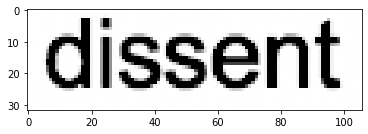

[[1. 0. 0.]]
dissent


In [350]:
image = image_target
plt.imshow(image)
plt.show()
image_lst = np.array([image], dtype=np.float32)
out_label_cat = classifier.predict(image_lst)
label_dict = {0: 'dissent', 1: 'assent', 2: 'other'}
print(out_label_cat)
print(label_dict[np.argmax(out_label_cat)])

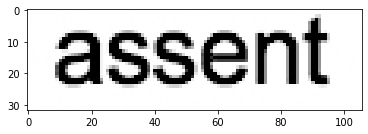

[[0. 1. 0.]]
assent


In [351]:
image = image_init
plt.imshow(image)
plt.show()
image_lst = np.array([image], dtype=np.float32)
out_label_cat = classifier.predict(image_lst)
label_dict = {0: 'dissent', 1: 'assent', 2: 'other'}
print(out_label_cat)
print(label_dict[np.argmax(out_label_cat)])

HopSkipJump: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1825.20it/s]


Adversarial image at step 0. L2 error 12494.711 and Tesseract output assent.


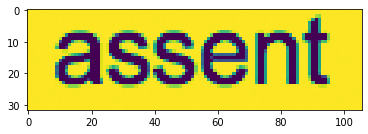

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.17s/it]


Adversarial image at step 30. L2 error 8509.935 and Tesseract output assent.


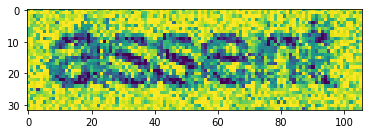

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.24s/it]


Adversarial image at step 60. L2 error 7406.4473 and Tesseract output assent.


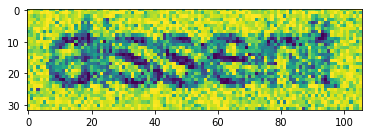

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.29s/it]


Adversarial image at step 90. L2 error 7202.415 and Tesseract output assent.


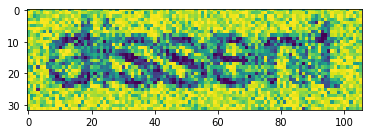

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.65s/it]


Adversarial image at step 120. L2 error 6982.7925 and Tesseract output assent.


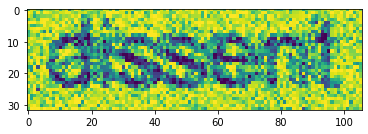

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.26s/it]


Adversarial image at step 150. L2 error 6952.5967 and Tesseract output assent.


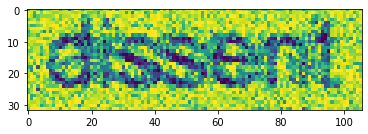

In [352]:
attack = HopSkipJump(classifier=classifier, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = np.array([image_init], dtype=np.float32)
for i in range(16):
    x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, y=to_categorical([1], 3))
    if i%3 == 0:
        print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
              np.linalg.norm(np.reshape(x_adv[0] - image_target, [-1])),
              "and Tesseract output %s." % label_dict[np.argmax(classifier.predict(x_adv)[0])])
        plt.imshow(x_adv[0,:,:,0])
        plt.show(block=False)

    attack.max_iter = iter_step

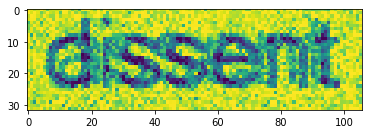

assent



In [115]:
tmp = x_adv.astype(np.uint8)
plt.imshow(tmp[0,:,:,0])
plt.show()
print(pytesseract.image_to_string(tmp[0]))

# -------------------------------------------

In [457]:
# init_text_lst = ['Covid \n is bad','Covid \n is not a \n consipracy','Covid Vaccines \n are effective','Covid \n is not \n a lie']
# target_text_lst = ['Covid \n is good','Covid \n is a \n consipracy','Covid Vaccines \n are ineffective','Covid is a lie']

# image_init_lst = []
# for text in init_text_lst:
#     img = create_OCR_image(text)
#     image_init_lst.append(img)
#     plt.imshow(img)
#     plt.show()

# image_target_lst = []
# for text in target_text_lst:
#     img = create_OCR_image(text)
#     image_target_lst.append(img)
#     plt.imshow(img)
#     plt.show()

In [238]:
def create_OCR_image(text):
    image_size = (106, 32)
    img_colour = (255, 255, 255)
    img = Image.new('RGB', image_size, color=img_colour)
    image_editable = ImageDraw.Draw(img)
    text_colour = (0, 0, 0)
    text_font_size = 18
    text_font = ImageFont.truetype('./fonts/raleway/Raleway-Bold.ttf', text_font_size)
    image_editable.text((25,5), text, fill=text_colour, font=text_font)
    img = np.array(img)
    plt.imshow(img)
    return img

def create_OCR_image_1(text):
    image_size = (106, 32)
    img_colour = (255, 255, 255)
    img = Image.new('RGB', image_size, color=img_colour)
    image_editable = ImageDraw.Draw(img)
    text_colour = (0, 0, 0)
    text_font_size = 18
    text_font = ImageFont.truetype('./fonts/raleway/Raleway-Bold.ttf', text_font_size)
    image_editable.text((10,5), text, fill=text_colour, font=text_font)
    img = np.array(img)
    plt.imshow(img)
    return img

def compress_image(img):
    ht, wid, _ = img.shape
    reduce_factor = math.ceil(ht/250)
    print(reduce_factor)
    new_ht = int(ht/reduce_factor)
    new_wid = int(wid/reduce_factor)
    res = cv2.resize(img, dsize=(new_wid, new_ht), interpolation=cv2.INTER_CUBIC)
    print(img.shape)
    print(res.shape)
    return res

def resize_adversary_image(img, adversary):
    ht, wid, _ = img.shape
    adversary_res = cv2.resize(adversary, dsize=(wid, ht), interpolation=cv2.INTER_CUBIC)
    print(adversary.shape)
    print(adversary_res.shape)
    return adversary_res

def predict(x):
    out_label = []
    for x_i in x:
        x_i = x_i.astype(np.uint8)
        out_string = pytesseract.image_to_string(x_i).strip()
#         print('`'+out_string+'`')
#         if out_string:
#             out_string = out_string.split()[0]
        rmv_words_lst = ['\n']
        for rmv_word in rmv_words_lst:
            out_string = out_string.replace('\n',' ')
        out_string = re.split(', | |_|-|/|!|\+', out_string)
#         out_string = out_string.split(" ")
#         print(out_string)
        for word in out_string:
            if word == 'VACCINATION' or word == '':
                break
        if word == 'VACCINATION':
                out_label.append(0)
        elif word == '':
            out_label.append(1)
        else:
            out_label.append(2)
    out_label_cat = to_categorical(out_label, 3)
    return out_label_cat

def predict_text(model, image, label_dict):
    plt.imshow(image[:,:,0])
    plt.show()
    image_lst = np.array([image], dtype=np.float32)
    out_label_cat = model.predict(image_lst)
    print(label_dict[np.argmax(out_label_cat)])
    
def create_mask(model, image_init, image_target, label_dict):
    attack = HopSkipJump(classifier=model, targeted=True, norm=2, max_iter=0, max_eval=1000, init_eval=10)
    iter_step = 10
    l2_error_lst = []
    x_adv = np.array([image_init], dtype=np.float32)
    i=0
    for i in range(2):
        x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, y=to_categorical([1], 3))
        l2_error = np.linalg.norm(np.reshape(x_adv[0]-image_target,[-1]))
        l2_error_lst.append(l2_error)
        print("Adversarial image at step %d." % (i*iter_step))
        print("L2 error: %.6f" %l2_error)
        print("Tesseract output is: %s." % label_dict[np.argmax(model.predict(x_adv)[0])])
        plt.imshow(x_adv[0,:,:,0])
        plt.show(block=False)
        attack.max_iter = iter_step
        if i>=1 and abs(l2_error_lst[-2]-l2_error_lst[-1])/l2_error_lst[-2]<0.01:
            break
    return x_adv, l2_error_lst



In [572]:
#Antonyms

accurate - inaccurate
appear - disappear
approve - disapprove
advantage - disadvantage
courteous - discourteous
can - cant
careful - careless
comfort - discomfort
correct - incorrect
capable - incapable
decrease - increase
disappear - appear
discourage - encourage
downwards - upwards
definite - indefinite
encourage - discourage

NameError: name 'accurate' is not defined

In [19]:
# #Text that you want the model to read
# init_word = 'definite'
# #Text that you want to show on the image
# target_word = 'indefinite'
# label_dict = {0: target_word, 1: init_word, 2: 'other'}

# image_init = create_OCR_image(init_word)
# image_target = create_OCR_image_1(target_word)


# model = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255))
# predict_text(model, image_init, label_dict)
# predict_text(model, image_target, label_dict)

3
(720, 1280, 3)
(240, 426, 3)
(516, 736, 3)
(240, 426, 3)


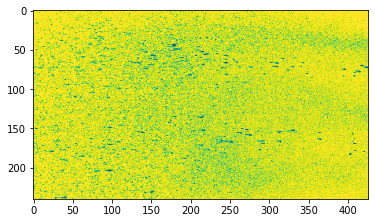

No_word


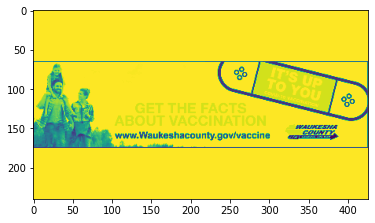

VACCINATION


In [248]:
#Text that you want the model to read
init_word = 'No_word'
#Text that you want to show on the image
target_word = 'VACCINATION'
label_dict = {0: target_word, 1: init_word, 2: 'other'}

image_target = imageio.imread('./Images/Vaccination/vaccination_6.png')
image_target = compress_image(image_target)

image_init = imageio.imread('./Images/Vaccination/d5m49xe-88f608e6-a2e5-42b6-980e-149070b2b6fd.jpeg')
image_init = resize_adversary_image(image_target, image_init)

model = BlackBoxClassifier(predict, image_target.shape, 3, clip_values=(0, 255))
predict_text(model, image_init, label_dict)
predict_text(model, image_target, label_dict)

In [252]:
image_init = imageio.imread('./Images/Vaccination/d5m49xe-88f608e6-a2e5-42b6-980e-149070b2b6fd.png')
image_init.shape

(485, 989, 4)

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 929.38it/s]


Adversarial image at step 0.
L2 error: 34990.074219
Tesseract output is: No_word.


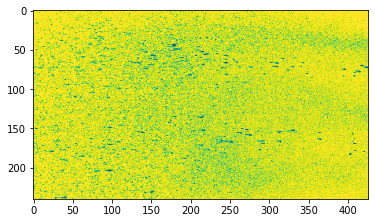

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:00<00:00, 60.22s/it]


Adversarial image at step 10.
L2 error: 14966.767578
Tesseract output is: No_word.


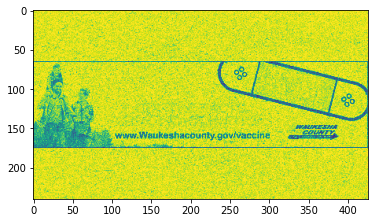

CPU times: user 28.2 s, sys: 10.8 s, total: 39.1 s
Wall time: 1min 1s


In [249]:
%%time
adv_img, l2_error_lst = create_mask(model, image_init, image_target, label_dict)

After perturbation


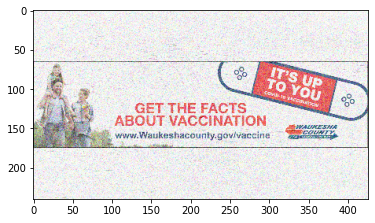

Tesseract output: _GET THE FACTS
ABOUT VACCI NATION.
woiWhakoshacourty.dovveccine ~ SECIS




In [250]:
#finally verify

adv_img_copy = adv_img.astype(np.uint8)
plt.imshow(adv_img_copy[0,:,:,:])
print('After perturbation')
plt.show()
print("Tesseract output: "+pytesseract.image_to_string(adv_img_copy[0]))

In [214]:
# Save perturbed Image

# perturbed_image_path = './Images/Vaccination/vaccination__perturbed.png'
imageio.imwrite(perturbed_image_path, adv_img[0])

Lossy conversion from float32 to uint8. Range [0.0043129646219313145, 255.0]. Convert image to uint8 prior to saving to suppress this warning.
